In [0]:
import pandas as pd
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import sys
if 'google.colab' in sys.modules:
  %tensorflow_version 2.x
import tensorflow as tf
from google.colab import drive
from sklearn.utils import shuffle
from keras.utils.np_utils import to_categorical
from keras.datasets import cifar10
from keras.regularizers import l2

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
AUTO = tf.data.experimental.AUTOTUNE

## Set up TPU and GPU usage

In [2]:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
except ValueError:
  tpu = None
  gpus = tf.config.experimental.list_logical_devices("GPU")

if tpu:
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)
  print('Running on TPU ', tpu.master())  
elif len(gpus) > 0:
  strategy = tf.distribute.MirroredStrategy(gpus)
  print('Running on ', len(gpus), ' GPU(s) ')
else:
  strategy = tf.distribute.get_strategy()
  print('Running on CPU')

Running on  1  GPU(s) 


## Read data

In [0]:
IMG_SIZE = [32, 32]
BATCH_SIZE = 128

In [4]:
(X, Y), (X_test, Y_test) = cifar10.load_data()
Y = to_categorical(Y, num_classes=10)
Y_test = to_categorical(Y_test, num_classes=10)

170500096/170498071 [==============================] - 4s 0us/step


In [5]:
X.shape, Y.shape, X_test.shape, Y_test.shape

((50000, 32, 32, 3), (50000, 10), (10000, 32, 32, 3), (10000, 10))

In [0]:
label_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

## Zero center and scale to unit variance

In [7]:
np.isnan(X).sum(), np.isnan(X_test).sum()

(0, 0)

In [0]:
def norm_data(X):
  X = X / 255.0
  X = X - X.mean(axis=0)
  X = X / X.std(axis=0)

  return X

In [0]:
X = norm_data(X)
X_test = norm_data(X_test)

In [10]:
X.mean(), X_test.mean()

(-5.123870809124279e-14, 1.0134100965804767e-14)

In [11]:
X.std(axis=0).sum() / (32 * 32 * 3), X_test.std(axis=0).sum() / (32 * 32 * 3)

(1.000000000000001, 0.9999999999999999)

## Convert Data to batches and augment data

In [0]:
def data_augment(image, label):
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_saturation(image, lower=0.5, upper=1.5)

  return image, label

In [0]:
def get_batched_dataset(dataset, train=False):
  if train:
    dataset = dataset.repeat()
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.shuffle(1337)

  dataset = dataset.batch(BATCH_SIZE)
  dataset = dataset.prefetch(AUTO)
  return dataset

In [0]:
X = tf.dtypes.cast(X, tf.float32)
Y = tf.dtypes.cast(Y, tf.float32)
tf.keras.backend.set_floatx('float32')

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices((X, Y))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

train = get_batched_dataset(train_dataset, train=True)
test = get_batched_dataset(test_dataset)

In [0]:
l = tf.keras.layers

## Inception architecture

In [0]:
def inception(squeeze, expand, filters):
  inp = tf.keras.Input(shape=(*IMG_SIZE, filters))
  y1 = l.Conv2D(squeeze, 1,activation='relu')(inp)
  y1 = l.BatchNormalization()(y1)
  y1 = l.Conv2D(expand//4, 3, padding='same',activation='relu')(y1)
  y1 = l.BatchNormalization()(y1)

  y2 = l.Conv2D(squeeze, 1, activation='relu')(inp)
  y2 = l.BatchNormalization()(y2)
  y2 = l.Conv2D(expand//4, 3, padding='same',activation='relu')(y2)
  y2 = l.BatchNormalization()(y2)
  y2 = l.Conv2D(expand//4, 3, padding='same',activation='relu')(y2)
  y2 = l.BatchNormalization()(y2)

  y3 = l.Conv2D(expand//4, 3, padding='same',activation='relu')(inp)
  y3 = l.BatchNormalization()(y3)
  y3 = l.Conv2D(expand//4, 3, padding='same',activation='relu')(y3)
  y3 = l.BatchNormalization()(y3)

  y4 = l.Conv2D(expand//4, 1, activation='relu')(inp)
  y4 = l.BatchNormalization()(y4)

  output = l.concatenate([y1, y2, y3, y4])

  model = tf.keras.Model(inputs=[inp], outputs=[output])
  
  return model

In [0]:
def create_inception_net():
  x = l.Input(shape=[*IMG_SIZE, 3])
  y = l.Conv2D(16, 6, padding='same', activation='relu')(x)
  y = l.BatchNormalization()(y)
  y = inception(16, 32, 16)(y)
  y = l.MaxPooling2D()(y)
  y = l.Dropout(0.1)(y)

  y = inception(32, 64, 32)(y)
  y = inception(64, 128, 64)(y)
  y = l.MaxPooling2D()(y)
  y = l.Dropout(0.2)(y)
  
  y = inception(32, 64, 128)(y)
  y = l.MaxPooling2D()(y)
  y = l.Dropout(0.3)(y)


  y = inception(16, 32, 64)(y)
  y = l.Flatten()(y)
  y = l.Dense(100, activation='relu')(y)
  y = l.Dense(10, activation='softmax')(y)

  model = tf.keras.Model(x, y)

  model.compile(
      loss='categorical_crossentropy',
      optimizer='adam',
      metrics=['accuracy']
  )

  return model

## ResNet architecture

In [0]:
def lr_fun(x):
  lr = 1e-3
  if x > 50:
    lr *= 1e-1
  elif x > 100:
    lr *= 1e-2
    
  return lr

In [0]:
def conv_module(x, dims=-1):
  if dims == -1:
    dims = x.shape[3]

  y1 = l.Conv2D(dims, 3, padding='same',activation='relu', strides=2, kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(x)
  y1 = l.BatchNormalization()(y1)
  y1 = l.Conv2D(dims, 3, padding='same', activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(y1)
  y1 = l.BatchNormalization()(y1)

  y2 = l.Conv2D(dims, 3, padding='same',activation='relu', strides=2, kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(x)
  y2 = l.BatchNormalization()(y2)
  y2 = l.Conv2D(dims, 3, padding='same', activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(y2)
  y2 = l.BatchNormalization()(y2)

  y3 = l.Conv2D(dims, 3, padding='same',activation='relu', strides=2, kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(x)
  y3 = l.BatchNormalization()(y3)
  y3 = l.Conv2D(dims, 3, padding='same', activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(y3)
  y3 = l.BatchNormalization()(y3)

  y4 = l.Conv2D(dims, 1, padding='same', strides=2)(x)
  y4 = l.BatchNormalization()(y4)

  return l.add([y1, y2, y3, y4])

In [0]:
def identity_module(x):
  dims = x.shape[3]
  

  y1 = l.Conv2D(dims, 3, padding='same', activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(x)
  y1 = l.BatchNormalization()(y1)
  y1 = l.Conv2D(dims, 3, padding='same', activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(y1)
  y1 = l.BatchNormalization()(y1)

  y2 = l.Conv2D(dims, 3, padding='same', activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(x)
  y2 = l.BatchNormalization()(y2)
  y2 = l.Conv2D(dims, 3, padding='same', activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(y2)
  y2 = l.BatchNormalization()(y2)

  y3 = l.Conv2D(dims, 3, padding='same', activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(x)
  y3 = l.BatchNormalization()(y3)
  y3 = l.Conv2D(dims, 3, padding='same', activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(y3)
  y3 = l.BatchNormalization()(y3)

  y4 = l.Conv2D(dims, 3, padding='same', activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(x)
  y4 = l.BatchNormalization()(y4)
  y4 = l.Conv2D(dims, 3, padding='same', activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(y4)
  y4 = l.BatchNormalization()(y4)

  return l.add([x, y1, y2, y3, y4])

In [0]:
def create_resnet():
  x = l.Input(shape=(*IMG_SIZE, 3))
  
  y = l.Conv2D(16, 3, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(x)
  y = l.BatchNormalization()(y)
  y = l.Dropout(0.1)(y)

  y = conv_module(y, 32)
  y = identity_module(y)
  y = l.Dropout(0.2)(y)

  y = conv_module(y, 64)
  y = identity_module(y)
  y = l.Dropout(0.3)(y)

  y = l.AveragePooling2D(pool_size=8)(y)
  y = l.Flatten()(y)
  y = l.Dense(10, activation='softmax')(y)

  model = tf.keras.Model(x, y)

  model.compile(
      loss='categorical_crossentropy',
      optimizer='adam',
      metrics=['accuracy']
      )
  
  return model

## Model creation and training

In [104]:
with strategy.scope():
  model = create_resnet()

  model.summary()
  #print(model.count_params())

Model: "model_25"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_632 (Conv2D)             (None, 32, 32, 16)   448         input_27[0][0]                   
__________________________________________________________________________________________________
batch_normalization_839 (BatchN (None, 32, 32, 16)   64          conv2d_632[0][0]                 
__________________________________________________________________________________________________
dropout_77 (Dropout)            (None, 32, 32, 16)   0           batch_normalization_839[0][0]    
___________________________________________________________________________________________

In [105]:
EPOCHS = 75

annealer = tf.keras.callbacks.LearningRateScheduler(lr_fun)
steps_per_epoch = X.shape[0] // BATCH_SIZE

history = model.fit(train,
                    steps_per_epoch=steps_per_epoch, 
                    epochs=EPOCHS, 
                    validation_data=test,
                    callbacks=[annealer]
                    )

Train for 390 steps, validate for 79 steps
Epoch 1/75
390/390 [==============================] - 28s 73ms/step - loss: 1.7212 - accuracy: 0.4796 - val_loss: 1.5826 - val_accuracy: 0.5418
Epoch 2/75
390/390 [==============================] - 20s 52ms/step - loss: 1.3236 - accuracy: 0.6267 - val_loss: 1.2951 - val_accuracy: 0.6468
Epoch 3/75
390/390 [==============================] - 20s 52ms/step - loss: 1.1347 - accuracy: 0.6902 - val_loss: 1.1226 - val_accuracy: 0.6991
Epoch 4/75
390/390 [==============================] - 20s 52ms/step - loss: 1.0088 - accuracy: 0.7353 - val_loss: 1.0069 - val_accuracy: 0.7360
Epoch 5/75
390/390 [==============================] - 20s 52ms/step - loss: 0.9136 - accuracy: 0.7659 - val_loss: 0.9103 - val_accuracy: 0.7742
Epoch 6/75
390/390 [==============================] - 20s 51ms/step - loss: 0.8415 - accuracy: 0.7904 - val_loss: 0.8757 - val_accuracy: 0.7835
Epoch 7/75
390/390 [==============================] - 20s 52ms/step - loss: 0.7872 - accuracy

In [0]:
def display_training_curves(training, validation, title, subplot):
  #stolen from google cnn tutorial
  if subplot%10==1:
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

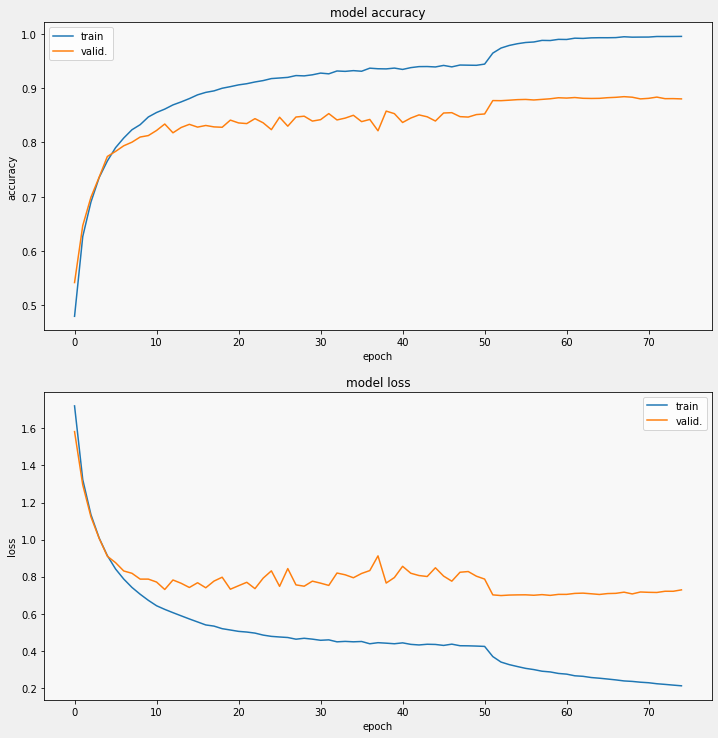

In [107]:
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

## View some examples

In [0]:
def plot_CIFAR(X, ind):
    pic = X[ind]
    R = pic[:,:,0]
    G = pic[:,:,1]
    B = pic[:,:,2]
 
    img = np.dstack((R,G,B))
    fig = plt.figure(figsize=(3,3))
    ax = fig.add_subplot(111)
    ax.imshow(img,interpolation='bicubic')


In [0]:
def prediction_vs_true(X, ind):
  predicted_label = label_names[np.argmax(model.predict(tf.expand_dims(X[ind], 0)))]
  print("Model prediction:", predicted_label)
  print("Correct prediction:", label_names[np.argmax(Y[ind])])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Model prediction: automobile
Correct prediction: automobile


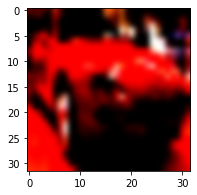

In [110]:
plot_CIFAR(X, 5)
prediction_vs_true(X, 5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Model prediction: horse
Correct prediction: horse


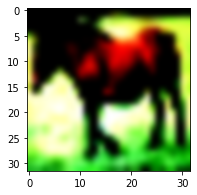

In [111]:
plot_CIFAR(X, 7)
prediction_vs_true(X, 7)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Model prediction: airplane
Correct prediction: airplane


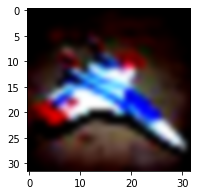

In [112]:
plot_CIFAR(X, 30)
prediction_vs_true(X, 30)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Model prediction: deer
Correct prediction: deer


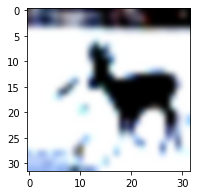

In [113]:
plot_CIFAR(X, 20)
prediction_vs_true(X, 20)